# Near miss asteroids for Earth in 2021 and 2022

## This project will compare data from the NASA Near Earth Object Web Service for 2021 and 2022 and take a further look into how close and potentially how dangerous some asteroids were to Earth. 

### More information about the project including how to get the project working on your computer is located in the readme in the directory of this project. 

In [1]:
import os
import calendar
import requests
import json
import datetime
import pandas as pd 
import glob
import matplotlib.pyplot as plt

# 1. Getting our asteroid data

## This section is optional and will show the method I used to download the NeoWs data for 2021 from NASA using their API. The process can be long so if you are not wanting to sign up for an API key from the NASA website and download the data manually, the needed data is included in the data/2021/original folder in the directory. I have commented out key sections of this script to prevent accidently running it as it can take upwards of 5 minutes to download all files. If you are wanting to run this script to test it out, please look into the readme under the section titled "1. Getting our asteroid data." 

In [ ]:
# Here is the script to download the json files
url = "https://api.nasa.gov/neo/rest/v1/feed"
# Remove this to use the API key: api_key = "*insert API key here*"

# Specify the start and end dates for the first week and the folder path
start_date = "2021-01-01"
end_date = "2021-01-07"
folder_path = "data/2021/downloaded"

# Our api only allows 7 days at a time, so let's iterate over the start and end dates for 7 days at a time (see below)
while start_date <= "2021-12-31":

    parameters = {
        "start_date": start_date,
        "end_date": end_date,
        "api_key": api_key
    }

    # Here is our actual API request
    response = requests.get(url, params=parameters)

    # Here we will save the file with a custom filename for the week it contains
    if response.status_code == 200:
        data = response.json()
        asteroids = data["near_earth_objects"]
        file_name = f"week_{start_date}.json"
        file_path = os.path.join(folder_path, file_name)

        # Save the json file and output a confirmation that the file was downloaded successfully
        with open(file_path, "w") as file:
            json.dump(asteroids, file)
            print(f"JSON data for {start_date} to {end_date} saved successfully.")
            #If this is successful, you will see 53 success responses, may take 5-10 minutes
    else:
        print(f"Failed to retrieve data for {start_date} to {end_date} from the API.")
  
        
    # Here we can use strptime, strftime from the datetime library to convert the start/end date to datetime elements
    # Then we can add 7 days to that datetime element and convert the value back to a string to be used in the request
    start_date = (datetime.datetime.strptime(start_date, "%Y-%m-%d") + datetime.timedelta(days=7)).strftime("%Y-%m-%d")
    end_date = (datetime.datetime.strptime(end_date, "%Y-%m-%d") + datetime.timedelta(days=7)).strftime("%Y-%m-%d")

# Now that we have our 2021 data, let's use the same script as above for our 2022 data, with the dates changed. Again as stated above, key portions of the script have been commented out to prevent the script from running accidently. 

In [ ]:
# Here is the script to download the json files
url = "https://api.nasa.gov/neo/rest/v1/feed"
# Remove this to input API key: api_key = "*insert API key here*"

# Start/end dates
start_date = "2022-01-01"
end_date = "2022-01-07"
folder_path = "data/2022/downloaded"

# Parameters
while start_date <= "2022-12-31":

    parameters = {
        "start_date": start_date,
        "end_date": end_date,
        "api_key": api_key
    }

    # API request
    response = requests.get(url, params=parameters)

    
    if response.status_code == 200:
        data = response.json()
        asteroids = data["near_earth_objects"]
        file_name = f"week_{start_date}.json"
        file_path = os.path.join(folder_path, file_name)

        # Confirmation message
        with open(file_path, "w") as file:
            json.dump(asteroids, file)
            print(f"JSON data for {start_date} to {end_date} saved successfully.")
            #If this is successful, you will see 53 success responses, may take 5-10 minutes
    else:
        print(f"Failed to retrieve data for {start_date} to {end_date} from the API.")
  
        
    start_date = (datetime.datetime.strptime(start_date, "%Y-%m-%d") + datetime.timedelta(days=7)).strftime("%Y-%m-%d")
    end_date = (datetime.datetime.strptime(end_date, "%Y-%m-%d") + datetime.timedelta(days=7)).strftime("%Y-%m-%d")

# 2. Cleaning our NeoWs data

## Here we will be scraping our json files for only the specified data we want and putting that into a dataframe

## If you are downloading the data yourself to test out the code, please read the readme for this section under "2. Cleaning our NeoWs data" for the changes you need to make, otherwise you can leave this section as-is if you are using the included "original" data.


In [2]:
# This will be for the 2021 data
asteroid_data = []

# Let's use glob to iterate over the file names of our json files, and then load the json files into the data variable
for file_name in glob.glob('data/2021/original/*.json'):
    with open(file_name) as file:
        data = json.load(file)
        
        # This loop allows us to iterate over each asteroid and take out particular data from each asteroid
        for date, asteroids in data.items():
            for asteroid in asteroids:
                asteroid_id = asteroid['id']
                asteroid_name = asteroid['name']
                asteroid_diameter_min = asteroid['estimated_diameter']['feet']['estimated_diameter_min']
                asteroid_diameter_max = asteroid['estimated_diameter']['feet']['estimated_diameter_max']
                asteroid_potentially_hazardous = asteroid['is_potentially_hazardous_asteroid']
                
                # Since we have a nested list in our json, we have to create a nested loop for this data
                for approach in asteroid['close_approach_data']:
                    
                    asteroid_relative_velocity = approach['relative_velocity']['miles_per_hour']
                    asteroid_miss_distance = approach['miss_distance']['miles']
                    asteroid_date = approach['close_approach_date']
                    
                    # Here we append our dictionary and create our new column names
                    asteroid_data.append({
                        'ID': asteroid_id,
                        'Name': asteroid_name,
                        'Diameter_Min_Feet': asteroid_diameter_min,
                        'Diameter_Max_Feet': asteroid_diameter_max,
                        'Relative_Velocity_MPH': asteroid_relative_velocity,
                        'Miss_Distance_Miles': asteroid_miss_distance,
                        'Is_Potentially_Hazardous': asteroid_potentially_hazardous,
                        'Date': asteroid_date
                    })
            
df = pd.DataFrame(asteroid_data)

# Let's add a column to give us the average estimated diameter
df['Average_Diameter_Feet'] = (df['Diameter_Min_Feet'] + df['Diameter_Max_Feet']) / 2

# Next let's convert our data from year-month-day to month-day-year
# We can do this by converting the date to date-time type and then changing the format
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%m-%d-%Y')

# Now let's rearrange the columns to make it easier to read
column_order = ['Date', 'Name', 'Diameter_Min_Feet', 'Diameter_Max_Feet', 'Average_Diameter_Feet', 'Relative_Velocity_MPH', 'Miss_Distance_Miles', 'Is_Potentially_Hazardous', 'ID']
df = df[column_order]

# Finally, lets sort our dataframe based on the date
df.sort_values('Date', inplace=True)


# Just in case you want to see it in excel, remove the # before the next line
#df.to_excel('data/2021asteroidoutput.xlsx', index=False)

In [3]:
# This will be for our 2022 data
asteroid_data = []

for file_name in glob.glob('data/2022/original/*.json'):
    with open(file_name) as file:
        data = json.load(file)
        
        
        for date, asteroids in data.items():
            for asteroid in asteroids:
                asteroid_id = asteroid['id']
                asteroid_name = asteroid['name']
                asteroid_diameter_min = asteroid['estimated_diameter']['feet']['estimated_diameter_min']
                asteroid_diameter_max = asteroid['estimated_diameter']['feet']['estimated_diameter_max']
                asteroid_potentially_hazardous = asteroid['is_potentially_hazardous_asteroid']
                
                # Remember the nested lists
                for approach in asteroid['close_approach_data']:
                    
                    asteroid_relative_velocity = approach['relative_velocity']['miles_per_hour']
                    asteroid_miss_distance = approach['miss_distance']['miles']
                    asteroid_date = approach['close_approach_date']
                    
                    # Here we append our dictionary and create our new column names
                    asteroid_data.append({
                        'ID': asteroid_id,
                        'Name': asteroid_name,
                        'Diameter_Min_Feet': asteroid_diameter_min,
                        'Diameter_Max_Feet': asteroid_diameter_max,
                        'Relative_Velocity_MPH': asteroid_relative_velocity,
                        'Miss_Distance_Miles': asteroid_miss_distance,
                        'Is_Potentially_Hazardous': asteroid_potentially_hazardous,
                        'Date': asteroid_date
                    })

# Let's create a different data frame for the 2022 data
df2 = pd.DataFrame(asteroid_data)

# Let's add a column to give us the average estimated diameter
df2['Average_Diameter_Feet'] = (df2['Diameter_Min_Feet'] + df2['Diameter_Max_Feet']) / 2

# Next let's convert our data from year-month-day to month-day-year
# We can do this by converting the date to date-time type and then changing the format
df2['Date'] = pd.to_datetime(df2['Date'])
df2['Date'] = df2['Date'].dt.strftime('%m-%d-%Y')

# Now let's rearrange the columns to make it easier to read
column_order = ['Date', 'Name', 'Diameter_Min_Feet', 'Diameter_Max_Feet', 'Average_Diameter_Feet', 'Relative_Velocity_MPH', 'Miss_Distance_Miles', 'Is_Potentially_Hazardous', 'ID']
df2 = df2[column_order]

# Finally, lets sort our dataframe based on the date
df2.sort_values('Date', inplace=True)

#df2.to_excel('data/2022asteroidoutput.xlsx', index=False)

# 3. Merging our data frames

## Both these data frames are organized basically the same way, now lets combine the two so we can do some visualizing 

In [13]:
# Let's concatenate the two data frames
combined_df = pd.concat([df, df2], ignore_index=True)

# Let's format our date column ahead of time to something that looks better
combined_df['Date'] = pd.to_datetime(combined_df['Date']).dt.strftime('%m-%d-%Y')

# Sort the combined data frame by the Date column
combined_df.sort_values(by='Date', inplace=True)

# Then we reset our index
combined_df.reset_index(drop=True, inplace=True)

#combined_df.to_excel('data/combined_asteroidoutput.xlsx', index=False)

In [26]:
# Let's create some values to help with our visualization 

# Convert the Date column to datetime objects to make sure we can pull the correct dates
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Extract the year and month from the Date column
combined_df['year'] = combined_df['Date'].dt.year
combined_df['month'] = combined_df['Date'].dt.month

# Now let's make new data frames for our potentially hazardous asteroids
hazardous21_df = combined_df[(combined_df['Is_Potentially_Hazardous'] == True) & (combined_df['year'] == 2021)]
hazardous22_df = combined_df[(combined_df['Is_Potentially_Hazardous'] == True) & (combined_df['year'] == 2022)]

# For future plots, I will create some values for ease of use later
# First we make a combined dataframe for our particular years. 
combined_df_2021 = combined_df[combined_df['year'] == 2021]
combined_df_2022 = combined_df[combined_df['year'] == 2022]

# Now for our average diameter values
average_diameter_2021 = combined_df_2021.groupby('month')['Average_Diameter_Feet'].mean()
average_diameter_2022 = combined_df_2022.groupby('month')['Average_Diameter_Feet'].mean()


# 4. Visualizing our data

## Now things get fun, we get to make our data look nice 

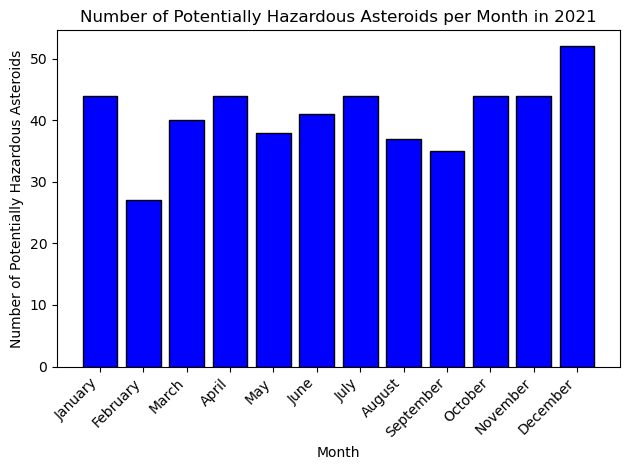

In [22]:
# Let's start with a simple bar graph of potentially hazardous asteroids, per month, for the year 2021
# We can also create our 2022 values as well 

# Create copies of the dataframes to avoid the SettingWithCopyWarning
hazardous21_df_copy = hazardous21_df.copy()
hazardous22_df_copy = hazardous22_df.copy()

# Convert the Date column to datetime objects and extract the month for both years
hazardous21_df_copy['Date'] = pd.to_datetime(hazardous21_df_copy['Date']).dt.date
hazardous21_df_copy['month'] = pd.to_datetime(hazardous21_df_copy['Date']).dt.month

hazardous22_df_copy['Date'] = pd.to_datetime(hazardous22_df_copy['Date']).dt.date
hazardous22_df_copy['month'] = pd.to_datetime(hazardous22_df_copy['Date']).dt.month

# Group the data by month for both years to get the counts for each month
hazardous_counts_per_month_2021 = hazardous21_df_copy['month'].value_counts().sort_index()
hazardous_counts_per_month_2022 = hazardous22_df_copy['month'].value_counts().sort_index()

# Create the bar graph
months = [calendar.month_name[i] for i in range(1, 13)]

plt.bar(months, hazardous_counts_per_month_2021, color='blue', edgecolor='black')

plt.xlabel('Month')
plt.ylabel('Number of Potentially Hazardous Asteroids')
plt.title('Number of Potentially Hazardous Asteroids per Month in 2021')

# Now we rotate the x-axis tick labels by 45 degrees for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# That looks good, now that we know our new data frames are plotting well, let's start doing some comparisons of 2021-2022 asteroids. We can make a simple double-bar graph to show a side-by-side view of the years data.

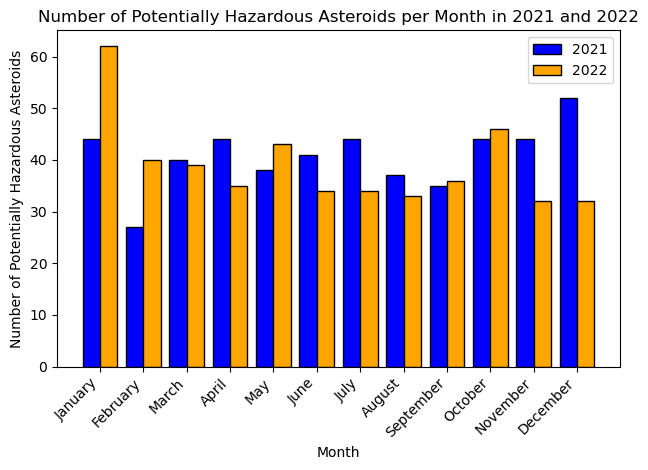

In [23]:
width = 0.4

plt.bar(months, hazardous_counts_per_month_2021, width, color='blue', edgecolor='black', label='2021')
plt.bar([i + width for i in range(len(months))], hazardous_counts_per_month_2022, width, color='orange', edgecolor='black', label='2022')

plt.xlabel('Month')
plt.ylabel('Number of Potentially Hazardous Asteroids')
plt.title('Number of Potentially Hazardous Asteroids per Month in 2021 and 2022')

# Now we rotate the x-axis tick labels by 45 degrees for better readability
plt.xticks([i + width/2 for i in range(len(months))], months, rotation=45, ha='right')

plt.legend()
plt.tight_layout()
plt.show()

# Looks like these asteroids have some healthy competition, Nov-Dec of 2021 had a big spike in potentitally hazardous asteroids, only for Jan-Feb of 2022 to come back and make a statement. 

# So, potentially hazardous asteroids is interesting to look at, but just how big are these asteroids?

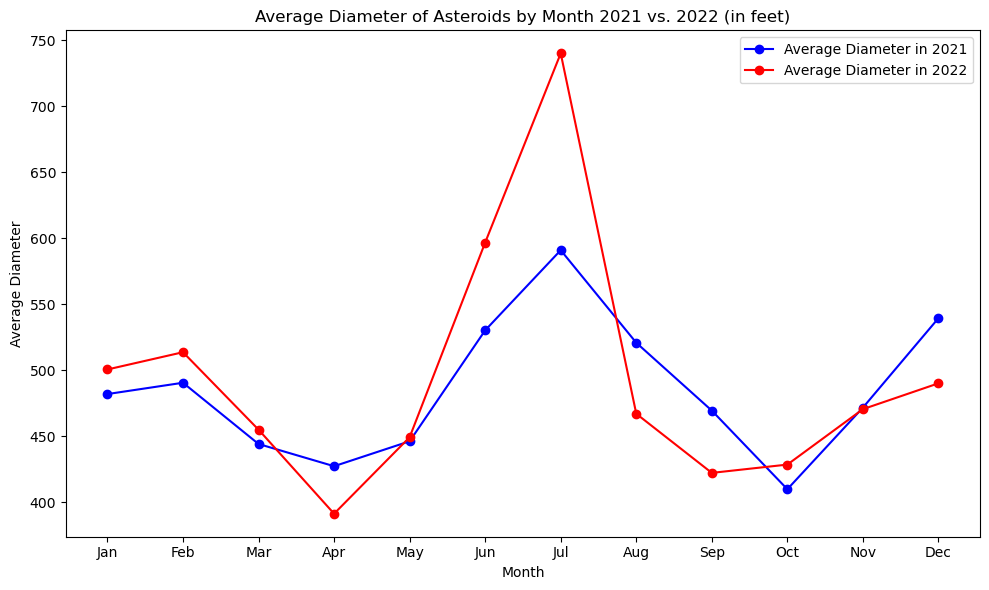

In [24]:
# Here are our months
months = range(1, 13)

# X-Axis labels for our months
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Creating the line plot
plt.figure(figsize=(10, 6))
plt.plot(months, average_diameter_2021, label='Average Diameter in 2021', marker='o', linestyle='-', color='blue')
plt.plot(months, average_diameter_2022, label='Average Diameter in 2022', marker='o', linestyle='-', color='red')

# Ticks for month names
plt.xticks(months, month_names)

plt.xlabel('Month')
plt.ylabel('Average Diameter')
plt.title('Average Diameter of Asteroids by Month 2021 vs. 2022 (in feet)')
plt.legend()

plt.tight_layout()
plt.show()

# Wow, those are some huge asteroids, lucky for us they did not impact Earth (although if they did, I wouldn't have to go into work tomorrow, but I digress). 

# Next, we will plot the average miss distance (in miles) that the asteroids missed Earth by

In [ ]:
# Make the values above where the other combined/diameter values are
# Convert the values in the average miss distance from a float to something else